In [1]:
import os
import json
import random
import itertools
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

import cartopy.crs as ccrs

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(os.path.abspath(".."))
from function import DOWN_raw
from function import ART_preprocessing as ART_pre

In [24]:
# product, time_reso = 'IMERG', '1dy'
product, time_reso = 'CMORPH', '3h'

In [25]:
yy_s, yy_e = 2002, 2012
lon_min, lon_max, lat_min, lat_max = 10.5, 13.5, 44.5, 47

In [27]:
json_read = f'../json/{product}_{time_reso}.json'

if os.path.exists(json_read):
    with open (json_read) as f:
        param = json.load(f)
else:
    raise SystemExit(f"File not found: {json_read}")

NEIBHR = 2*param['npix']+1

print(f'Read json file   : {json_read.split('/')[-1]}')
print(f'Number of threads: {param['BETA_cores']}')
print(f'Neighborhood area: {NEIBHR}x{NEIBHR}')
print()

Read json file   : CMORPH_3h.json
Number of threads: 25
Neighborhood area: 3x3



In [28]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite')

In [29]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
    VENETO_DEM = gpd.read_file(os.path.join(veneto_dir,'Veneto_DEM_1000.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [30]:
print(f'Reading data: {param['file']}')
if product == 'SM2RAIN':
    dir_data = os.path.join(dir_base,product,'ASCAT',time_reso,param['file'])
else:
    dir_data = os.path.join(dir_base,product,time_reso,param['file'])

PRE_data = xr.open_dataset(dir_data)
PRE_data = PRE_data.sel(time=PRE_data.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))

if product == 'MSWEP' or product == 'PERSIANN' or product == 'SM2RAIN' or product == 'ERA5' or product == 'GSMaP':
    PRE_data = PRE_data.sel(lat=slice(lat_max+1, lat_min-1), lon=slice(lon_min-1, lon_max+1))
else:
    PRE_data = PRE_data.sel(lat=slice(lat_min-1, lat_max+1), lon=slice(lon_min-1, lon_max+1))

lats = PRE_data['lat']
lons = PRE_data['lon']

lon2d, lat2d = np.meshgrid(lons, lats)

nlon = np.size(lons)
nlat = np.size(lats)
ntime = len(PRE_data['time'])

year_vector = np.unique(pd.to_datetime(PRE_data['time']).year)

PRE_data

Reading data: CMORPH_Italy_3hr_1998_01_01_2023_12_31.nc


<xarray.Dataset> Size: 47MB
Dimensions:  (time: 32144, lat: 18, lon: 20)
Coordinates:
  * lat      (lat) float32 72B 43.62 43.88 44.12 44.38 ... 47.38 47.62 47.88
  * lon      (lon) float32 80B 9.625 9.875 10.12 10.38 ... 13.88 14.12 14.38
  * time     (time) datetime64[ns] 257kB 2002-01-01 ... 2012-12-31T21:00:00
Data variables:
    PRE      (time, lat, lon) float32 46MB ...
Attributes:
    description:  CMORPH hourly data for Italy region in 1998 to 2023

In [31]:
# Extracting lat and lon points for Study area (VENETO)
if product == 'MSWEP' or product == 'PERSIANN' or product == 'SM2RAIN' or product == 'ERA5' or product == 'GSMaP':
    ds_veneto = PRE_data.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))
else:
    ds_veneto = PRE_data.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

lat_ref = ds_veneto.lat.values
lon_ref = ds_veneto.lon.values

ndices_lat = np.where(np.isin(lats, lat_ref))[0]
ndices_lon = np.where(np.isin(lons, lon_ref))[0]

lon2d_ref, lat2d_ref = np.meshgrid(lon_ref, lat_ref)

# del ds_veneto

In [32]:
PRE_daily = PRE_data.resample(time ='D').sum(dim='time', skipna=False)

In [34]:
lat_c = lats[ndices_lat[2]].values
lon_c = lons[ndices_lon[2]].values

In [35]:
box3 = ART_pre.create_box_v2(PRE_daily, lat_c, lon_c, 1)
box3_lon2d, box_3_lat2d = np.meshgrid(box3['lon'].values, box3['lat'].values)

lat_mask = lats.isin(box3['lat'].values)
lon_mask = lons.isin(box3['lon'].values)

box3_mask = xr.DataArray(np.outer(lat_mask, lon_mask),
                    coords={'lat': lats, 'lon': lons},
                    dims=['lat', 'lon'])

print(f'Box ART: {box3['PRE'].shape}')

Box ART: (4018, 3, 3)


In [36]:
box5 = ART_pre.create_box_v2(PRE_daily, lat_c, lon_c, 2)
box5_lon2d, box5_lat2d = np.meshgrid(box5['lon'].values, box5['lat'].values)

lat_mask = lats.isin(box5['lat'].values)
lon_mask = lons.isin(box5['lon'].values)

box5_mask = xr.DataArray(np.outer(lat_mask, lon_mask),
                    coords={'lat': lats, 'lon': lons},
                    dims=['lat', 'lon'])

print(f'Box ART: {box5['PRE'].shape}')

Box ART: (4018, 5, 5)


In [37]:
box7 = ART_pre.create_box_v2(PRE_daily, lat_c, lon_c, 3)
box7_lon2d, box7_lat2d = np.meshgrid(box7['lon'].values, box7['lat'].values)

lat_mask = lats.isin(box7['lat'].values)
lon_mask = lons.isin(box7['lon'].values)

box7_mask = xr.DataArray(np.outer(lat_mask, lon_mask),
                    coords={'lat': lats, 'lon': lons},
                    dims=['lat', 'lon'])

print(f'Box ART: {box7['PRE'].shape}')

Box ART: (4018, 7, 7)


## Compute autocorrelation parameters

In [38]:
box3_vdist, box3_vcorr = ART_pre.autocorrelation_neighborhood_v2(
                    box3, 
                    time_reso, 
                    param['target_t'], 
                    param['thresh'], 
                    cor_method = 'spearman')

vdisbox3_vdistt, box3_vcorr = np.array(box3_vdist), np.array(box3_vcorr)

In [39]:
box5_vdist, box5_vcorr = ART_pre.autocorrelation_neighborhood_v2(
                    box5, 
                    time_reso, 
                    param['target_t'], 
                    param['thresh'], 
                    cor_method = 'spearman')

box5_vdist, box5_vcorr = np.array(box5_vdist), np.array(box5_vcorr)

In [40]:
box3_gen_mar = DOWN_raw.down_corr(box3_vdist, box3_vcorr, param['L1'], acf='mar',
                use_ave=True, opt_method = 'genetic', disp=True, toll=0.002,
                plot=True)

box3_gen_str = DOWN_raw.down_corr(box3_vdist, box3_vcorr, param['L1'], acf='str',
                use_ave=True, opt_method = 'genetic', disp=True, toll=0.002,
                plot=True)

box3_lbf_mar = DOWN_raw.down_corr(box3_vdist, box3_vcorr, param['L1'], acf='mar',
                use_ave=True, opt_method = 'lbfgsb', disp=True, toll=0.002,
                plot=True)

differential_evolution step 1: f(x)= 0.012178490762761103
differential_evolution step 2: f(x)= 0.010201885082566201
differential_evolution step 3: f(x)= 0.010201885082566201
differential_evolution step 4: f(x)= 0.009777729198107434
differential_evolution step 5: f(x)= 0.0037193648379984633
differential_evolution step 6: f(x)= 0.0037193648379984633
differential_evolution step 7: f(x)= 0.0036574099462823887
differential_evolution step 8: f(x)= 0.0033560594755022793
differential_evolution step 9: f(x)= 0.0033560594755022793
differential_evolution step 10: f(x)= 0.0033560594755022793
differential_evolution step 11: f(x)= 0.0033273589609572087
Polishing solution with 'L-BFGS-B'
integration domain is zero
differential_evolution step 1: f(x)= 0.004139170957695471
differential_evolution step 2: f(x)= 0.003427965842115569
differential_evolution step 3: f(x)= 0.003346127092412312
differential_evolution step 4: f(x)= 0.0030966649399877116
differential_evolution step 5: f(x)= 0.0028384235661980625

In [41]:
box5_gen_mar = DOWN_raw.down_corr(box5_vdist, box5_vcorr, param['L1'], acf='mar',
                use_ave=True, opt_method = 'genetic', disp=True, toll=0.002,
                plot=True)

box5_gen_str = DOWN_raw.down_corr(box5_vdist, box5_vcorr, param['L1'], acf='str',
                use_ave=True, opt_method = 'genetic', disp=True, toll=0.002,
                plot=True)

box5_lbf_mar = DOWN_raw.down_corr(box5_vdist, box5_vcorr, param['L1'], acf='mar',
                use_ave=True, opt_method = 'lbfgsb', disp=True, toll=0.002,
                plot=True)

differential_evolution step 1: f(x)= 0.15639603366349014
differential_evolution step 2: f(x)= 0.15639603366349014
differential_evolution step 3: f(x)= 0.15639603366349014
differential_evolution step 4: f(x)= 0.15639603366349014
differential_evolution step 5: f(x)= 0.15554535036392442
differential_evolution step 6: f(x)= 0.15554535036392442
differential_evolution step 7: f(x)= 0.15554535036392442
differential_evolution step 8: f(x)= 0.15554535036392442
differential_evolution step 9: f(x)= 0.15554535036392442
differential_evolution step 10: f(x)= 0.15554535036392442
differential_evolution step 11: f(x)= 0.15554535036392442
differential_evolution step 12: f(x)= 0.15553896316220991
differential_evolution step 13: f(x)= 0.15553276912784972
differential_evolution step 14: f(x)= 0.15552966094174053
differential_evolution step 15: f(x)= 0.15552936346360738
Polishing solution with 'L-BFGS-B'
integration domain is zero
differential_evolution step 1: f(x)= 0.16367268413223118
differential_evoluti

In [42]:
xx3 = np.linspace(0, 100, 50)
box3_mar, _ = DOWN_raw.curve_fit(DOWN_raw.epl_fun, box3_vdist, box3_vcorr)

xx5 = np.linspace(0, 100, 50)
box5_mar, _ = DOWN_raw.curve_fit(DOWN_raw.epl_fun, box5_vdist, box5_vcorr)

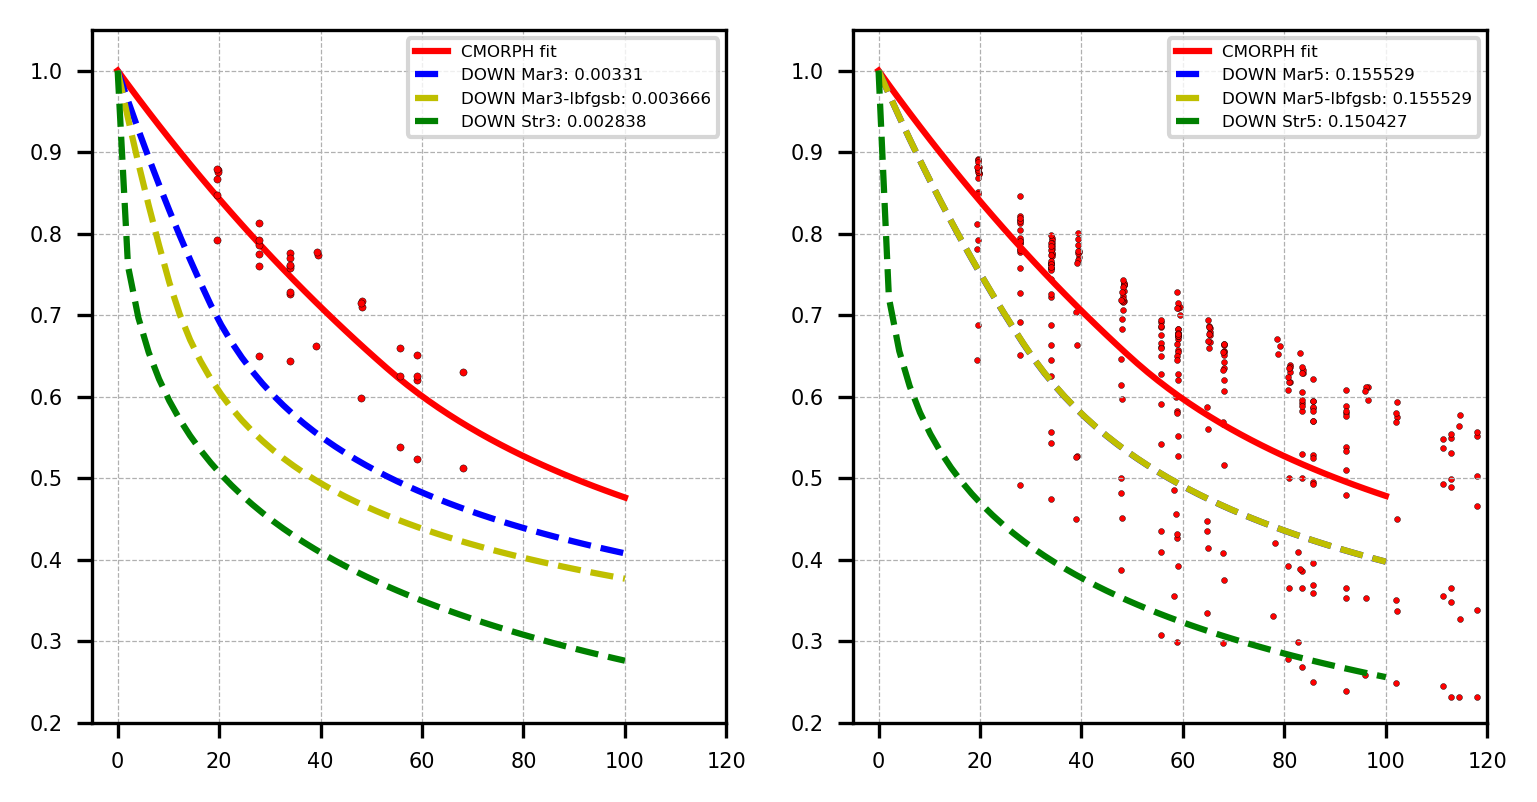

In [52]:
fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,2)

ax1 = plt.subplot(gs[0, 0])
ax1.scatter(box3_vdist,box3_vcorr,s=3,c='r',edgecolors='k',linewidths=0.1,zorder=10)
ax1.plot(xx3, DOWN_raw.epl_fun(xx3, box3_mar[0], box3_mar[1]), '-r', label=f'{product} fit')

ax1.plot(xx3, DOWN_raw.epl_fun(xx3, box3_gen_mar['eps_d'], box3_gen_mar['alp_d']), '--b', label=f'DOWN Mar3: {np.round(box3_gen_mar['funval'],6)}')
ax1.plot(xx3, DOWN_raw.epl_fun(xx3, box3_lbf_mar['eps_d'], box3_lbf_mar['alp_d']), '--y', label=f'DOWN Mar3-lbfgsb: {np.round(box3_lbf_mar['funval'],6)}')
ax1.plot(xx3, DOWN_raw.str_exp_fun(xx3, box3_gen_str['d0_d'], box3_gen_str['mu0_d']), '--g', label=f'DOWN Str3: {np.round(box3_gen_str['funval'],6)}')

ax1.set_ylim(0.2, 1.05)
ax1.set_xlim(-5, 120)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
plt.legend(fontsize=4)

ax1 = plt.subplot(gs[0, 1])
ax1.scatter(box5_vdist,box5_vcorr,s=2,c='r',edgecolors='k',linewidths=0.1)
ax1.plot(xx5, DOWN_raw.epl_fun(xx5, box5_mar[0], box5_mar[1]), '-r', label=f'{product} fit')

ax1.plot(xx5, DOWN_raw.epl_fun(xx5, box5_gen_mar['eps_d'], box5_gen_mar['alp_d']), '--b', label=f'DOWN Mar5: {np.round(box5_gen_mar['funval'],6)}')
ax1.plot(xx5, DOWN_raw.epl_fun(xx5, box5_lbf_mar['eps_d'], box5_lbf_mar['alp_d']), '--y', label=f'DOWN Mar5-lbfgsb: {np.round(box5_lbf_mar['funval'],6)}')
ax1.plot(xx5, DOWN_raw.str_exp_fun(xx5, box5_gen_str['d0_d'], box5_gen_str['mu0_d']), '--g', label=f'DOWN Str5: {np.round(box5_gen_str['funval'],6)}')

ax1.set_ylim(0.2, 1.05)
ax1.set_xlim(-5, 120)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
plt.legend(fontsize=4)

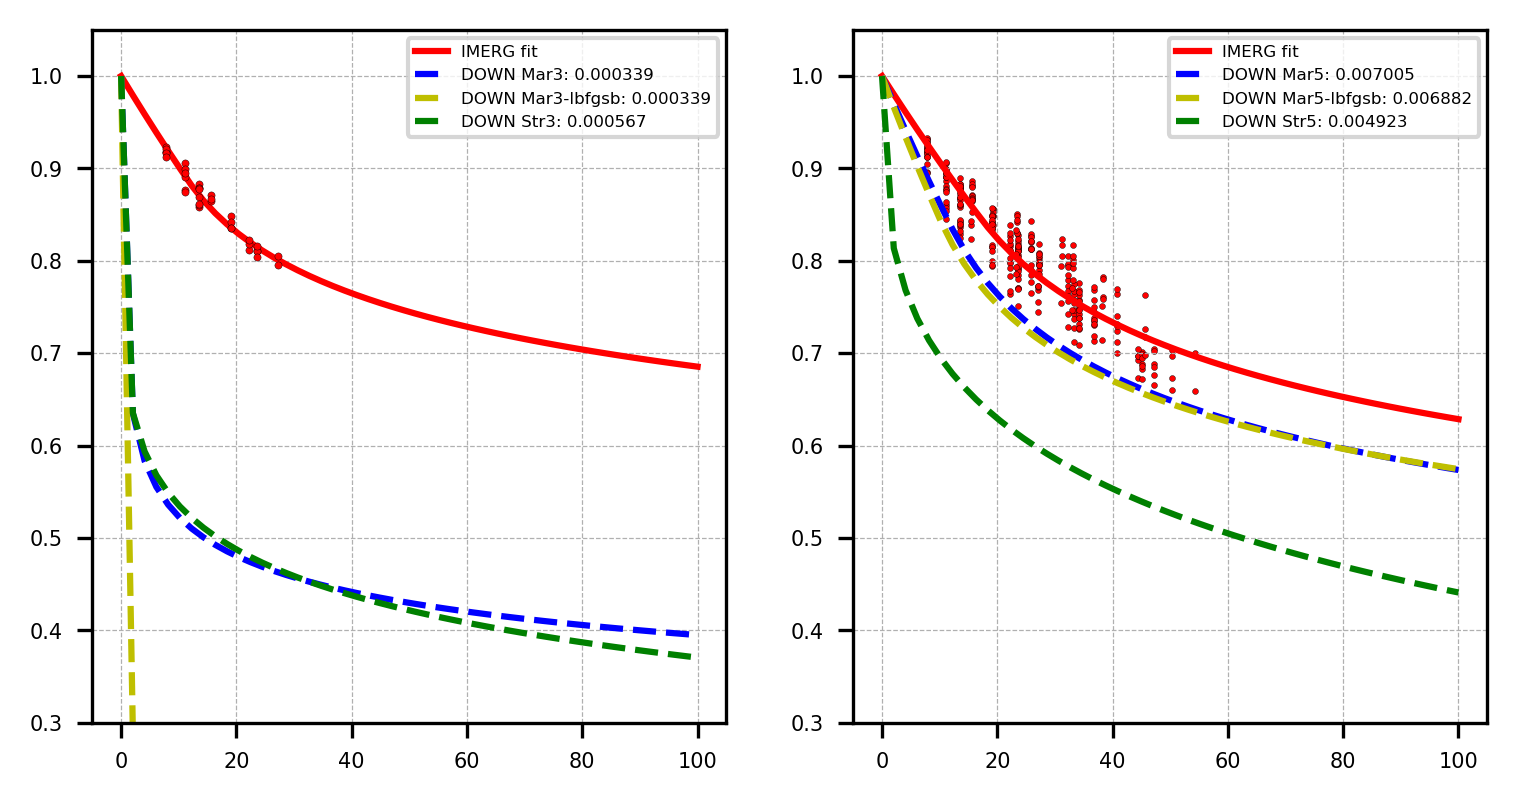

In [ ]:
fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,2)

ax1 = plt.subplot(gs[0, 0])
ax1.scatter(box3_vdist,box3_vcorr,s=3,c='r',edgecolors='k',linewidths=0.1,zorder=10)
ax1.plot(xx3, DOWN_raw.epl_fun(xx3, box3_mar[0], box3_mar[1]), '-r', label='IMERG fit')

ax1.plot(xx3, DOWN_raw.epl_fun(xx3, box3_gen_mar['eps_d'], box3_gen_mar['alp_d']), '--b', label=f'DOWN Mar3: {np.round(box3_gen_mar['funval'],6)}')
ax1.plot(xx3, DOWN_raw.epl_fun(xx3, box3_lbf_mar['eps_d'], box3_lbf_mar['alp_d']), '--y', label=f'DOWN Mar3-lbfgsb: {np.round(box3_lbf_mar['funval'],6)}')
ax1.plot(xx3, DOWN_raw.str_exp_fun(xx3, box3_gen_str['d0_d'], box3_gen_str['mu0_d']), '--g', label=f'DOWN Str3: {np.round(box3_gen_str['funval'],6)}')

ax1.set_ylim(0.3, 1.05)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
plt.legend(fontsize=4)

ax1 = plt.subplot(gs[0, 1])
ax1.scatter(box5_vdist,box5_vcorr,s=2,c='r',edgecolors='k',linewidths=0.1)
ax1.plot(xx5, DOWN_raw.epl_fun(xx5, box5_mar[0], box5_mar[1]), '-r', label='IMERG fit')

ax1.plot(xx5, DOWN_raw.epl_fun(xx5, box5_gen_mar['eps_d'], box5_gen_mar['alp_d']), '--b', label=f'DOWN Mar5: {np.round(box5_gen_mar['funval'],6)}')
ax1.plot(xx5, DOWN_raw.epl_fun(xx5, box5_lbf_mar['eps_d'], box5_lbf_mar['alp_d']), '--y', label=f'DOWN Mar5-lbfgsb: {np.round(box5_lbf_mar['funval'],6)}')
ax1.plot(xx5, DOWN_raw.str_exp_fun(xx5, box5_gen_str['d0_d'], box5_gen_str['mu0_d']), '--g', label=f'DOWN Str5: {np.round(box5_gen_str['funval'],6)}')

ax1.set_ylim(0.3, 1.05)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
plt.legend(fontsize=4)

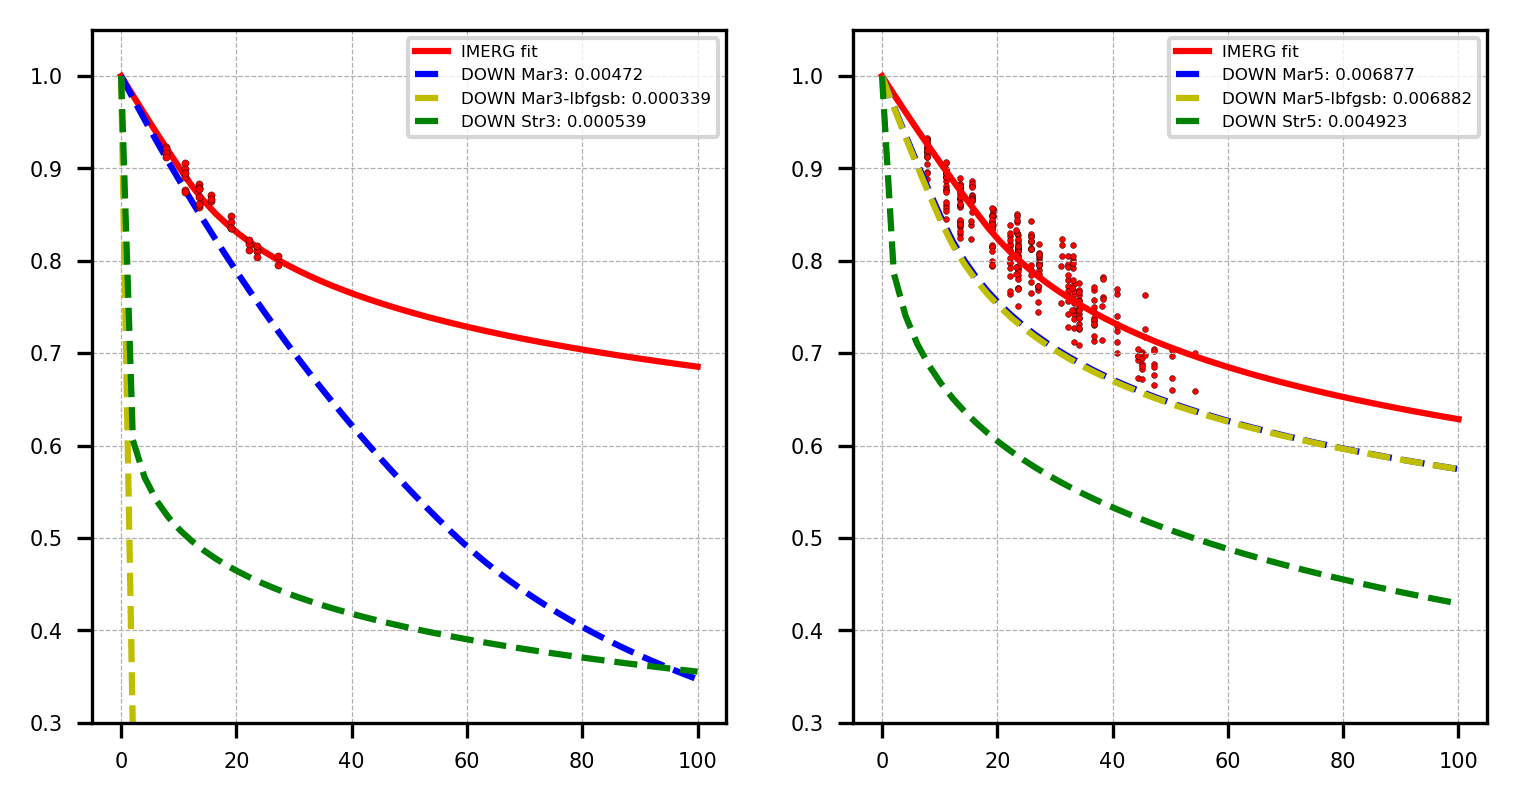

In [ ]:
fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,2)

ax1 = plt.subplot(gs[0, 0])
ax1.scatter(box3_vdist,box3_vcorr,s=3,c='r',edgecolors='k',linewidths=0.1,zorder=10)
ax1.plot(xx3, DOWN_raw.epl_fun(xx3, box3_mar[0], box3_mar[1]), '-r', label='IMERG fit')

ax1.plot(xx3, DOWN_raw.epl_fun(xx3, box3_gen_mar['eps_d'], box3_gen_mar['alp_d']), '--b', label=f'DOWN Mar3: {np.round(box3_gen_mar['funval'],6)}')
ax1.plot(xx3, DOWN_raw.epl_fun(xx3, box3_lbf_mar['eps_d'], box3_lbf_mar['alp_d']), '--y', label=f'DOWN Mar3-lbfgsb: {np.round(box3_lbf_mar['funval'],6)}')
ax1.plot(xx3, DOWN_raw.str_exp_fun(xx3, box3_gen_str['d0_d'], box3_gen_str['mu0_d']), '--g', label=f'DOWN Str3: {np.round(box3_gen_str['funval'],6)}')

ax1.set_ylim(0.3, 1.05)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
plt.legend(fontsize=4)

ax1 = plt.subplot(gs[0, 1])
ax1.scatter(box5_vdist,box5_vcorr,s=2,c='r',edgecolors='k',linewidths=0.1)
ax1.plot(xx5, DOWN_raw.epl_fun(xx5, box5_mar[0], box5_mar[1]), '-r', label='IMERG fit')

ax1.plot(xx5, DOWN_raw.epl_fun(xx5, box5_gen_mar['eps_d'], box5_gen_mar['alp_d']), '--b', label=f'DOWN Mar5: {np.round(box5_gen_mar['funval'],6)}')
ax1.plot(xx5, DOWN_raw.epl_fun(xx5, box5_lbf_mar['eps_d'], box5_lbf_mar['alp_d']), '--y', label=f'DOWN Mar5-lbfgsb: {np.round(box5_lbf_mar['funval'],6)}')
ax1.plot(xx5, DOWN_raw.str_exp_fun(xx5, box5_gen_str['d0_d'], box5_gen_str['mu0_d']), '--g', label=f'DOWN Str5: {np.round(box5_gen_str['funval'],6)}')

ax1.set_ylim(0.3, 1.05)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
plt.legend(fontsize=4)

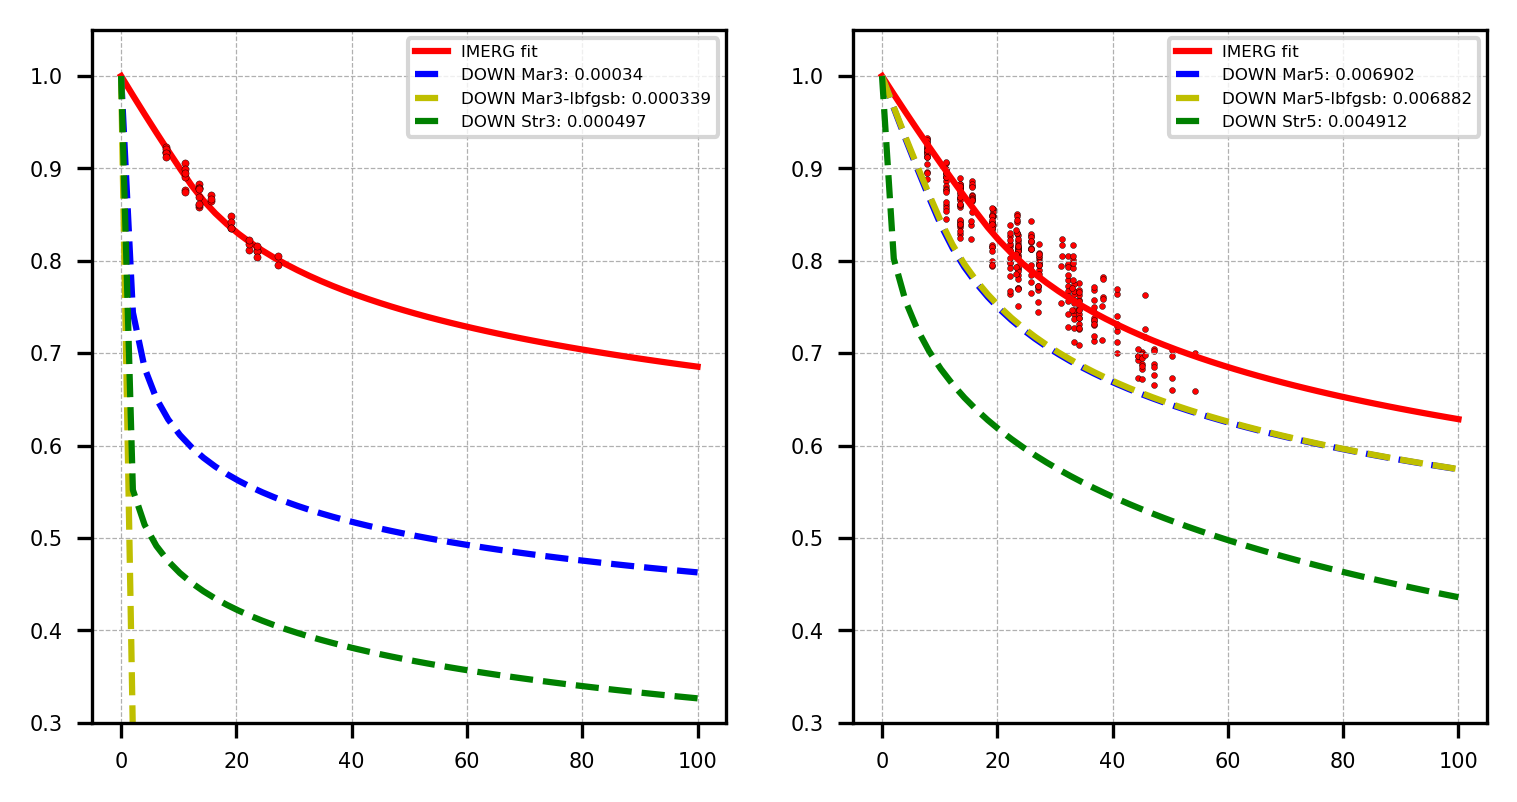

In [ ]:
fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,2)

ax1 = plt.subplot(gs[0, 0])
ax1.scatter(box3_vdist,box3_vcorr,s=3,c='r',edgecolors='k',linewidths=0.1,zorder=10)
ax1.plot(xx3, DOWN_raw.epl_fun(xx3, box3_mar[0], box3_mar[1]), '-r', label='IMERG fit')

ax1.plot(xx3, DOWN_raw.epl_fun(xx3, box3_gen_mar['eps_d'], box3_gen_mar['alp_d']), '--b', label=f'DOWN Mar3: {np.round(box3_gen_mar['funval'],6)}')
ax1.plot(xx3, DOWN_raw.epl_fun(xx3, box3_lbf_mar['eps_d'], box3_lbf_mar['alp_d']), '--y', label=f'DOWN Mar3-lbfgsb: {np.round(box3_lbf_mar['funval'],6)}')
ax1.plot(xx3, DOWN_raw.str_exp_fun(xx3, box3_gen_str['d0_d'], box3_gen_str['mu0_d']), '--g', label=f'DOWN Str3: {np.round(box3_gen_str['funval'],6)}')

ax1.set_ylim(0.3, 1.05)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
plt.legend(fontsize=4)

ax1 = plt.subplot(gs[0, 1])
ax1.scatter(box5_vdist,box5_vcorr,s=2,c='r',edgecolors='k',linewidths=0.1)
ax1.plot(xx5, DOWN_raw.epl_fun(xx5, box5_mar[0], box5_mar[1]), '-r', label='IMERG fit')

ax1.plot(xx5, DOWN_raw.epl_fun(xx5, box5_gen_mar['eps_d'], box5_gen_mar['alp_d']), '--b', label=f'DOWN Mar5: {np.round(box5_gen_mar['funval'],6)}')
ax1.plot(xx5, DOWN_raw.epl_fun(xx5, box5_lbf_mar['eps_d'], box5_lbf_mar['alp_d']), '--y', label=f'DOWN Mar5-lbfgsb: {np.round(box5_lbf_mar['funval'],6)}')
ax1.plot(xx5, DOWN_raw.str_exp_fun(xx5, box5_gen_str['d0_d'], box5_gen_str['mu0_d']), '--g', label=f'DOWN Str5: {np.round(box5_gen_str['funval'],6)}')

ax1.set_ylim(0.3, 1.05)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
plt.legend(fontsize=4)

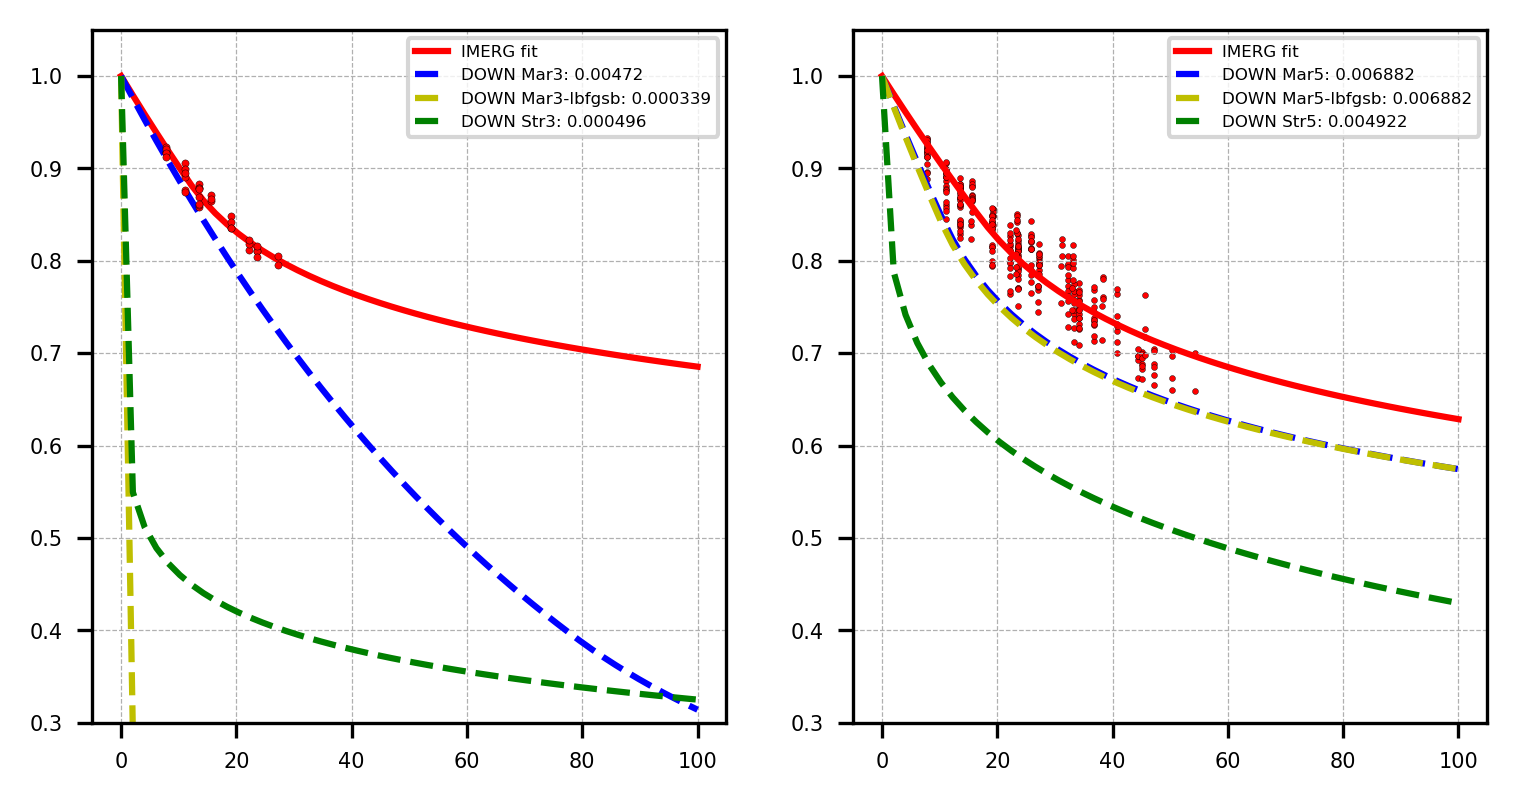

In [ ]:
fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,2)

ax1 = plt.subplot(gs[0, 0])
ax1.scatter(box3_vdist,box3_vcorr,s=3,c='r',edgecolors='k',linewidths=0.1,zorder=10)
ax1.plot(xx3, DOWN_raw.epl_fun(xx3, box3_mar[0], box3_mar[1]), '-r', label='IMERG fit')

ax1.plot(xx3, DOWN_raw.epl_fun(xx3, box3_gen_mar['eps_d'], box3_gen_mar['alp_d']), '--b', label=f'DOWN Mar3: {np.round(box3_gen_mar['funval'],6)}')
ax1.plot(xx3, DOWN_raw.epl_fun(xx3, box3_lbf_mar['eps_d'], box3_lbf_mar['alp_d']), '--y', label=f'DOWN Mar3-lbfgsb: {np.round(box3_lbf_mar['funval'],6)}')
ax1.plot(xx3, DOWN_raw.str_exp_fun(xx3, box3_gen_str['d0_d'], box3_gen_str['mu0_d']), '--g', label=f'DOWN Str3: {np.round(box3_gen_str['funval'],6)}')

ax1.set_ylim(0.3, 1.05)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
plt.legend(fontsize=4)

ax1 = plt.subplot(gs[0, 1])
ax1.scatter(box5_vdist,box5_vcorr,s=2,c='r',edgecolors='k',linewidths=0.1)
ax1.plot(xx5, DOWN_raw.epl_fun(xx5, box5_mar[0], box5_mar[1]), '-r', label='IMERG fit')

ax1.plot(xx5, DOWN_raw.epl_fun(xx5, box5_gen_mar['eps_d'], box5_gen_mar['alp_d']), '--b', label=f'DOWN Mar5: {np.round(box5_gen_mar['funval'],6)}')
ax1.plot(xx5, DOWN_raw.epl_fun(xx5, box5_lbf_mar['eps_d'], box5_lbf_mar['alp_d']), '--y', label=f'DOWN Mar5-lbfgsb: {np.round(box5_lbf_mar['funval'],6)}')
ax1.plot(xx5, DOWN_raw.str_exp_fun(xx5, box5_gen_str['d0_d'], box5_gen_str['mu0_d']), '--g', label=f'DOWN Str5: {np.round(box5_gen_str['funval'],6)}')

ax1.set_ylim(0.3, 1.05)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
plt.legend(fontsize=4)

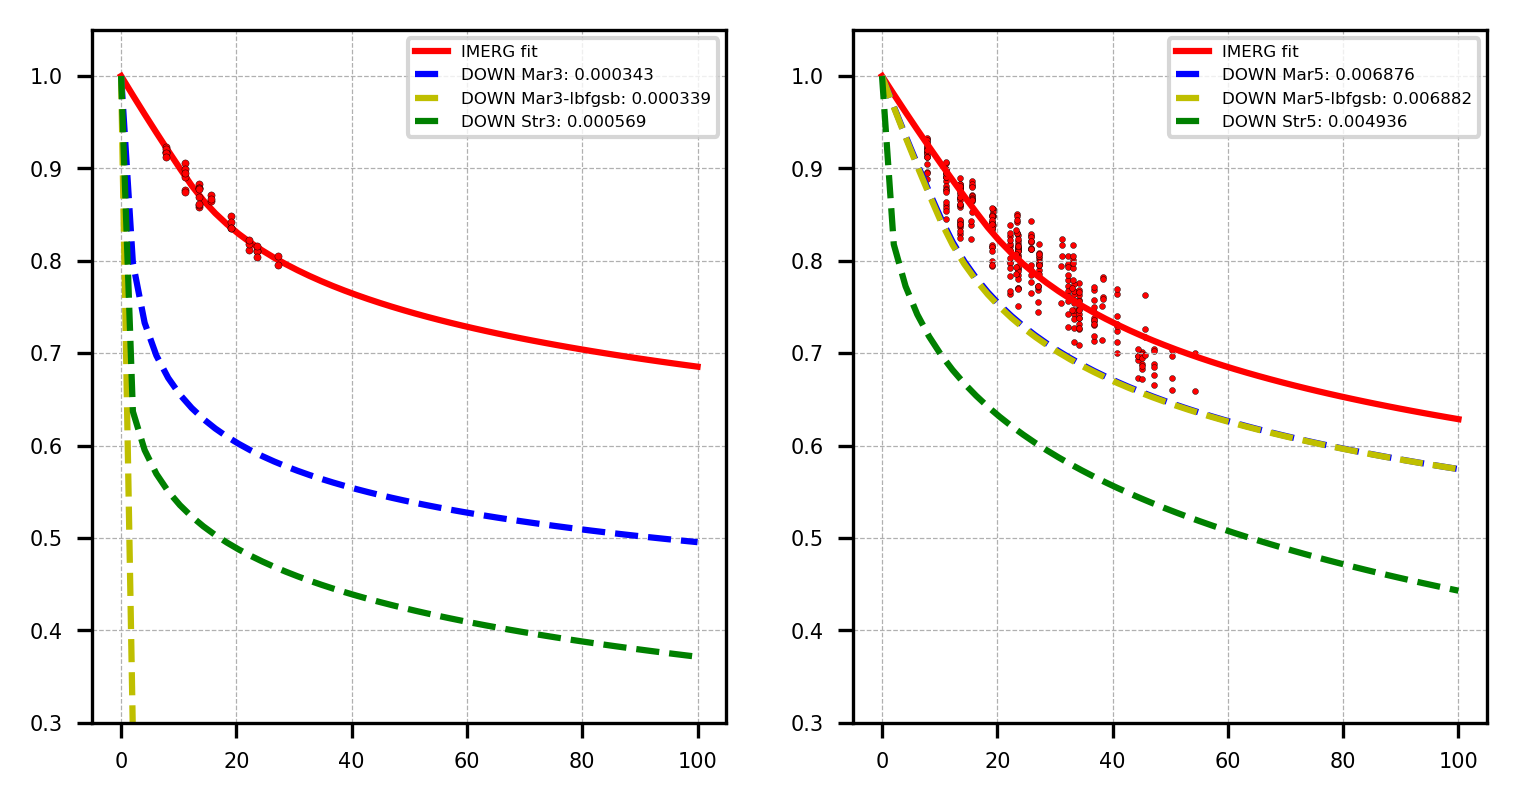

In [ ]:
fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,2)

ax1 = plt.subplot(gs[0, 0])
ax1.scatter(box3_vdist,box3_vcorr,s=3,c='r',edgecolors='k',linewidths=0.1,zorder=10)
ax1.plot(xx3, DOWN_raw.epl_fun(xx3, box3_mar[0], box3_mar[1]), '-r', label='IMERG fit')

ax1.plot(xx3, DOWN_raw.epl_fun(xx3, box3_gen_mar['eps_d'], box3_gen_mar['alp_d']), '--b', label=f'DOWN Mar3: {np.round(box3_gen_mar['funval'],6)}')
ax1.plot(xx3, DOWN_raw.epl_fun(xx3, box3_lbf_mar['eps_d'], box3_lbf_mar['alp_d']), '--y', label=f'DOWN Mar3-lbfgsb: {np.round(box3_lbf_mar['funval'],6)}')
ax1.plot(xx3, DOWN_raw.str_exp_fun(xx3, box3_gen_str['d0_d'], box3_gen_str['mu0_d']), '--g', label=f'DOWN Str3: {np.round(box3_gen_str['funval'],6)}')

ax1.set_ylim(0.3, 1.05)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
plt.legend(fontsize=4)

ax1 = plt.subplot(gs[0, 1])
ax1.scatter(box5_vdist,box5_vcorr,s=2,c='r',edgecolors='k',linewidths=0.1)
ax1.plot(xx5, DOWN_raw.epl_fun(xx5, box5_mar[0], box5_mar[1]), '-r', label='IMERG fit')

ax1.plot(xx5, DOWN_raw.epl_fun(xx5, box5_gen_mar['eps_d'], box5_gen_mar['alp_d']), '--b', label=f'DOWN Mar5: {np.round(box5_gen_mar['funval'],6)}')
ax1.plot(xx5, DOWN_raw.epl_fun(xx5, box5_lbf_mar['eps_d'], box5_lbf_mar['alp_d']), '--y', label=f'DOWN Mar5-lbfgsb: {np.round(box5_lbf_mar['funval'],6)}')
ax1.plot(xx5, DOWN_raw.str_exp_fun(xx5, box5_gen_str['d0_d'], box5_gen_str['mu0_d']), '--g', label=f'DOWN Str5: {np.round(box5_gen_str['funval'],6)}')

ax1.set_ylim(0.3, 1.05)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
plt.legend(fontsize=4)

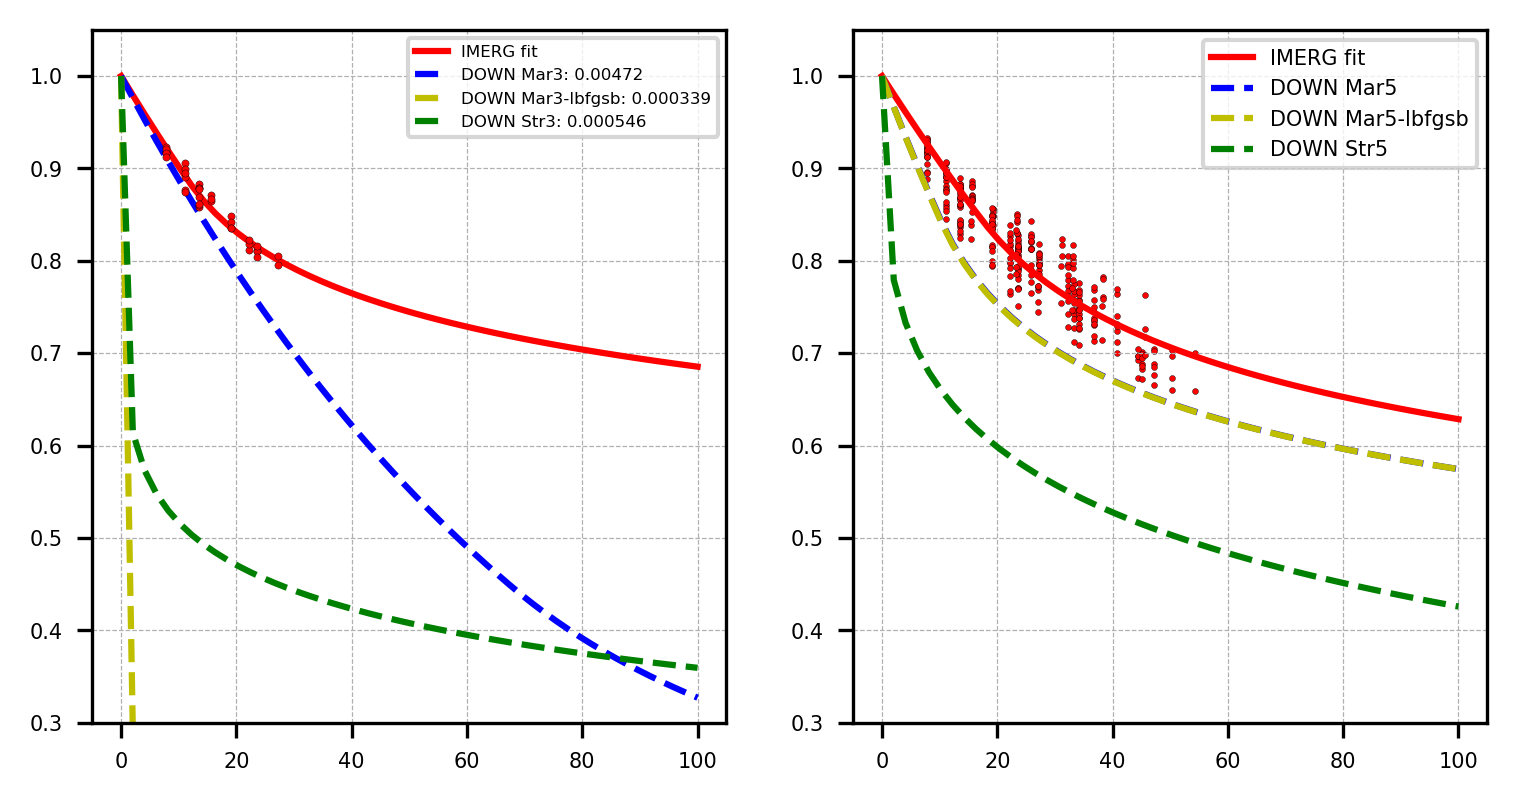

In [ ]:
fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,2)

ax1 = plt.subplot(gs[0, 0])
ax1.scatter(box3_vdist,box3_vcorr,s=3,c='r',edgecolors='k',linewidths=0.1,zorder=10)
ax1.plot(xx3, DOWN_raw.epl_fun(xx3, box3_mar[0], box3_mar[1]), '-r', label='IMERG fit')

ax1.plot(xx3, DOWN_raw.epl_fun(xx3, box3_gen_mar['eps_d'], box3_gen_mar['alp_d']), '--b', label=f'DOWN Mar3: {np.round(box3_gen_mar['funval'],6)}')
ax1.plot(xx3, DOWN_raw.epl_fun(xx3, box3_lbf_mar['eps_d'], box3_lbf_mar['alp_d']), '--y', label=f'DOWN Mar3-lbfgsb: {np.round(box3_lbf_mar['funval'],6)}')
ax1.plot(xx3, DOWN_raw.str_exp_fun(xx3, box3_gen_str['d0_d'], box3_gen_str['mu0_d']), '--g', label=f'DOWN Str3: {np.round(box3_gen_str['funval'],6)}')

ax1.set_ylim(0.3, 1.05)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
plt.legend(fontsize=4)

ax1 = plt.subplot(gs[0, 1])
ax1.scatter(box5_vdist,box5_vcorr,s=2,c='r',edgecolors='k',linewidths=0.1)
ax1.plot(xx5, DOWN_raw.epl_fun(xx5, box5_mar[0], box5_mar[1]), '-r', label='IMERG fit')

ax1.plot(xx5, DOWN_raw.epl_fun(xx5, box5_gen_mar['eps_d'], box5_gen_mar['alp_d']), '--b', label=f'DOWN Mar5: {np.round(box5_gen_mar['funval'],6)}')
ax1.plot(xx5, DOWN_raw.epl_fun(xx5, box5_lbf_mar['eps_d'], box5_lbf_mar['alp_d']), '--y', label=f'DOWN Mar5-lbfgsb: {np.round(box5_lbf_mar['funval'],6)}')
ax1.plot(xx5, DOWN_raw.str_exp_fun(xx5, box5_gen_str['d0_d'], box5_gen_str['mu0_d']), '--g', label=f'DOWN Str5: {np.round(box5_gen_str['funval'],6)}')

ax1.set_ylim(0.3, 1.05)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
plt.legend(fontsize=4)

## Test for improve results and avoid local minimum

In [14]:
from scipy.optimize import differential_evolution

def down_corr_v2(vdist, vcorr, L1, *, acf='mar',
                use_ave=True, opt_method = 'genetic', disp=True, toll=0.005,
                plot=False, repetitions=5):
    '''------------------------------------------------------------------------
    Downscale the correlation function obtained from spatial averages
    INPUT:
        ...
    ------------------------------------------------------------------------'''
    res = {}
    parnames = ['eps_d', 'alp_d'] if acf == 'mar' else ['d0_d', 'mu0_d']

    if not use_ave:
        def myfun(pardown):
            return DOWN_raw.myfun_sse(vdist, vcorr, pardown, L1, acf=acf)
    else:
        res_ave = DOWN_raw.bin_ave_corr(vdist, vcorr, toll=0.3, plot=plot)
        dd = res_ave['vdist_ave']
        cc = res_ave['vcorr_ave']
        def myfun(pardown):
            return DOWN_raw.myfun_sse(dd, cc, pardown, L1, acf=acf)

    # Ajustes de parámetros para el algoritmo evolutivo diferencial
    bounds = [(0.0, 200.0), (0.0, 1.00)]
    best_result = None
    best_value = float('inf')

    for _ in range(repetitions):
        # Ejecutar el algoritmo evolutivo diferencial varias veces
        # resmin = differential_evolution(
        #                 myfun, 
        #                 bounds, 
        #                 disp=disp,
        #                 tol=toll, 
        #                 atol=toll, 
        #                 maxiter=5000, 
        #                 popsize=20,
        #                 mutation=(0.5, 1), 
        #                 recombination=0.7)
        resmin = differential_evolution(
                        myfun,
                        bounds,
                        disp=disp,
                        tol=toll,
                        atol=toll,
                        maxiter=200,         # Menos iteraciones
                        popsize=10,          # Población más pequeña
                        mutation=(0.5, 1),
                        recombination=0.7,
                        seed=42              # Para resultados más reproducibles
                    )

        # Almacenar el mejor resultado
        if resmin.fun < best_value:
            best_value = resmin.fun
            best_result = resmin.x

    # Asignar los mejores parámetros encontrados
    res[parnames[0]] = best_result[0]
    res[parnames[1]] = best_result[1]
    res['success'] = True
    res['funval'] = best_value

    return res


In [ ]:
# TEST_gen_mar = down_corr_v2(box3_vdist, box3_vcorr, param['L1'], acf='mar',
#                 use_ave=True, opt_method = 'genetic', disp=True, toll=0.005,
#                 plot=True)

differential_evolution step 1: f(x)= 0.004722956248503882
differential_evolution step 2: f(x)= 0.004491669037266885
differential_evolution step 3: f(x)= 0.004102099339358529
differential_evolution step 4: f(x)= 0.0015154917387374975
differential_evolution step 5: f(x)= 0.0005849760309047258
differential_evolution step 6: f(x)= 0.0005849760309047258
differential_evolution step 7: f(x)= 0.0005849760309047258
differential_evolution step 8: f(x)= 0.0005849760309047258
Polishing solution with 'L-BFGS-B'
differential_evolution step 1: f(x)= 0.004722956248503882
differential_evolution step 2: f(x)= 0.004491669037266885
differential_evolution step 3: f(x)= 0.004102099339358529
differential_evolution step 4: f(x)= 0.0015154917387374975
differential_evolution step 5: f(x)= 0.0005849760309047258
differential_evolution step 6: f(x)= 0.0005849760309047258
differential_evolution step 7: f(x)= 0.0005849760309047258
differential_evolution step 8: f(x)= 0.0005849760309047258
Polishing solution with 'L-

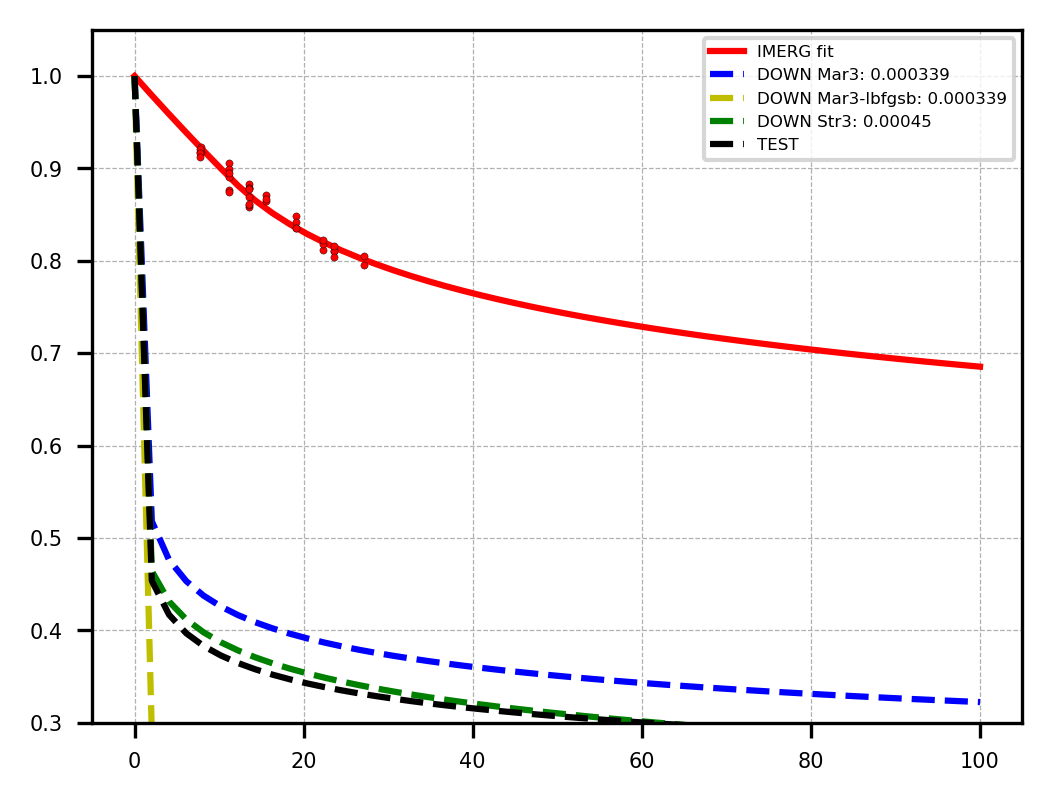

In [28]:
fig = plt.figure(figsize=(4,3),dpi=300)
gs = gridspec.GridSpec(1,1)

ax1 = plt.subplot(gs[0, 0])
ax1.scatter(box3_vdist,box3_vcorr,s=3,c='r',edgecolors='k',linewidths=0.1,zorder=10)
ax1.plot(xx3, DOWN_raw.epl_fun(xx3, box3_mar[0], box3_mar[1]), '-r', label='IMERG fit')

ax1.plot(xx3, DOWN_raw.epl_fun(xx3, box3_gen_mar['eps_d'], box3_gen_mar['alp_d']), '--b', label=f'DOWN Mar3: {np.round(box3_gen_mar['funval'],6)}')
ax1.plot(xx3, DOWN_raw.epl_fun(xx3, box3_lbf_mar['eps_d'], box3_lbf_mar['alp_d']), '--y', label=f'DOWN Mar3-lbfgsb: {np.round(box3_lbf_mar['fuvval'],6)}')
ax1.plot(xx3, DOWN_raw.str_exp_fun(xx3, box3_gen_str['d0_d'], box3_gen_str['mu0_d']), '--g', label=f'DOWN Str3: {np.round(box3_gen_str['funval'],6)}')

ax1.plot(xx3, DOWN_raw.epl_fun(xx3, TEST_gen_mar['eps_d'], TEST_gen_mar['alp_d']), '--k', label=f'TEST')

ax1.set_ylim(0.3, 1.05)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
plt.legend(fontsize=4)

* Parece que si influye el tamano de la vecindad en el algortimo para encontrar el valor optimo
* En la funcion de down cambiar box_fun creator from ZOR to ART
* Posiblmente los satelites con baja resolucion no les afecta tanto el tamano del box debido a la distancia mas grande entre puntos, sin embargo esto posiblemente si sea de consideracion para satelites com mayor resuolucion temporal (como en este ejemplo usando IMERG)
* Verificar como varia eresultados de box3 y box 5 para CMORPH o ERA5
* Compara los IMERG-fit the box3, box5 y box7

In [20]:
box7_vdist, box7_vcorr = ART_pre.autocorrelation_neighborhood_v2(
                    box7, 
                    time_reso, 
                    param['target_t'], 
                    param['thresh'], 
                    cor_method = 'spearman')

box7_vdist, box7_vcorr = np.array(box7_vdist), np.array(box7_vcorr)

box7_gen_mar = DOWN_raw.down_corr(box7_vdist, box7_vcorr, param['L1'], acf='mar',
                use_ave=True, opt_method = 'genetic', disp=True, toll=0.005,
                plot=True)

box7_gen_str = DOWN_raw.down_corr(box7_vdist, box7_vcorr, param['L1'], acf='str',
                use_ave=True, opt_method = 'genetic', disp=True, toll=0.005,
                plot=True)

box7_lbf_mar = DOWN_raw.down_corr(box7_vdist, box7_vcorr, param['L1'], acf='mar',
                use_ave=True, opt_method = 'lbfgsb', disp=True, toll=0.005,
                plot=True)

differential_evolution step 1: f(x)= 0.06318673851781467
differential_evolution step 2: f(x)= 0.056809541388150586
differential_evolution step 3: f(x)= 0.03557501052845028
differential_evolution step 4: f(x)= 0.03557501052845028
differential_evolution step 5: f(x)= 0.02885312786534295
differential_evolution step 6: f(x)= 0.02885312786534295
differential_evolution step 7: f(x)= 0.02885312786534295
differential_evolution step 8: f(x)= 0.02734427090555411
differential_evolution step 9: f(x)= 0.027008792557930747
differential_evolution step 10: f(x)= 0.027008792557930747
differential_evolution step 11: f(x)= 0.027008792557930747
differential_evolution step 12: f(x)= 0.027008792557930747
differential_evolution step 13: f(x)= 0.027008792557930747
Polishing solution with 'L-BFGS-B'
integration domain is zero
differential_evolution step 1: f(x)= 0.018320945508054125
differential_evolution step 2: f(x)= 0.018320945508054125
differential_evolution step 3: f(x)= 0.017759764797569768
differential_

In [89]:
xx7 = np.linspace(0, 100, 50)
box7_mar, _ = DOWN_raw.curve_fit(DOWN_raw.epl_fun, box7_vdist, box7_vcorr)

NameError: name 'box7_vdist' is not defined

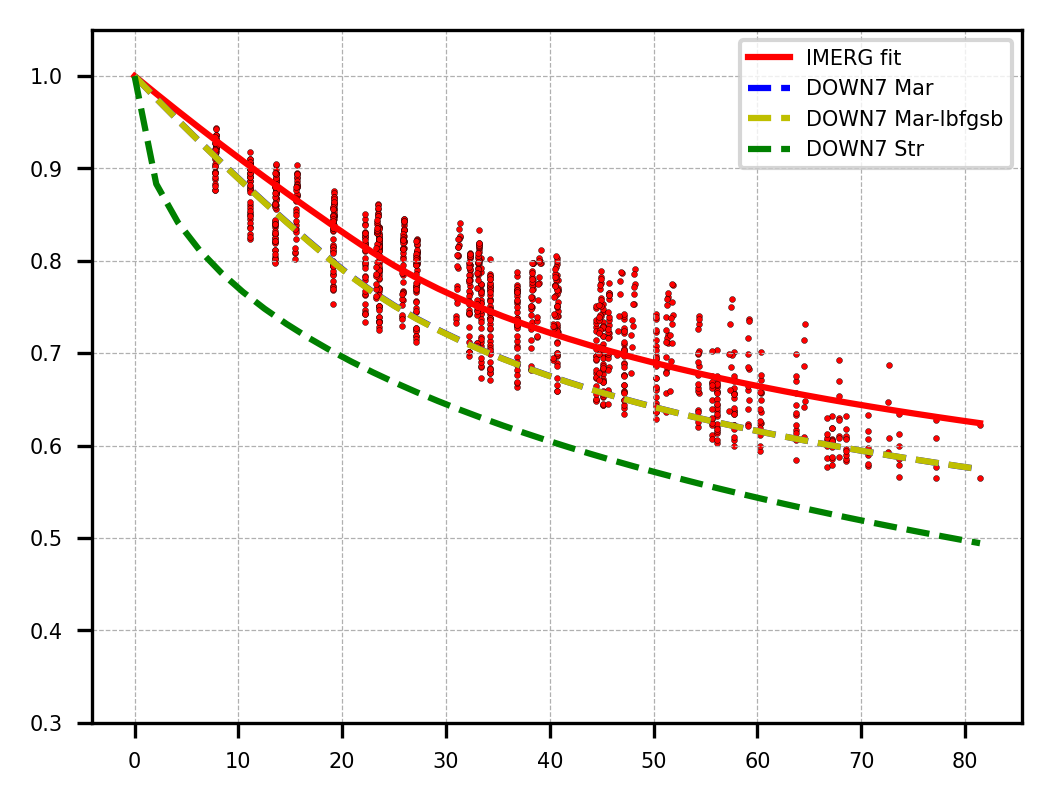

In [22]:
fig = plt.figure(figsize=(4,3),dpi=300)
gs = gridspec.GridSpec(1,1)

ax1 = plt.subplot(gs[0, 0])
ax1.scatter(box7_vdist,box7_vcorr,s=2,c='r',edgecolors='k',linewidths=0.1)
ax1.plot(xx7, DOWN_raw.epl_fun(xx7, box7_mar[0], box7_mar[1]), '-r', label='IMERG fit')

ax1.plot(xx7, DOWN_raw.epl_fun(xx7, box7_gen_mar['eps_d'], box7_gen_mar['alp_d']), '--b', label='DOWN7 Mar')
ax1.plot(xx7, DOWN_raw.epl_fun(xx7, box7_lbf_mar['eps_d'], box7_lbf_mar['alp_d']), '--y', label='DOWN7 Mar-lbfgsb')

ax1.plot(xx7, DOWN_raw.str_exp_fun(xx7, box7_gen_str['d0_d'], box7_gen_str['mu0_d']), '--g', label='DOWN7 Str')

ax1.set_ylim(0.3, 1.05)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
plt.legend(fontsize=5)

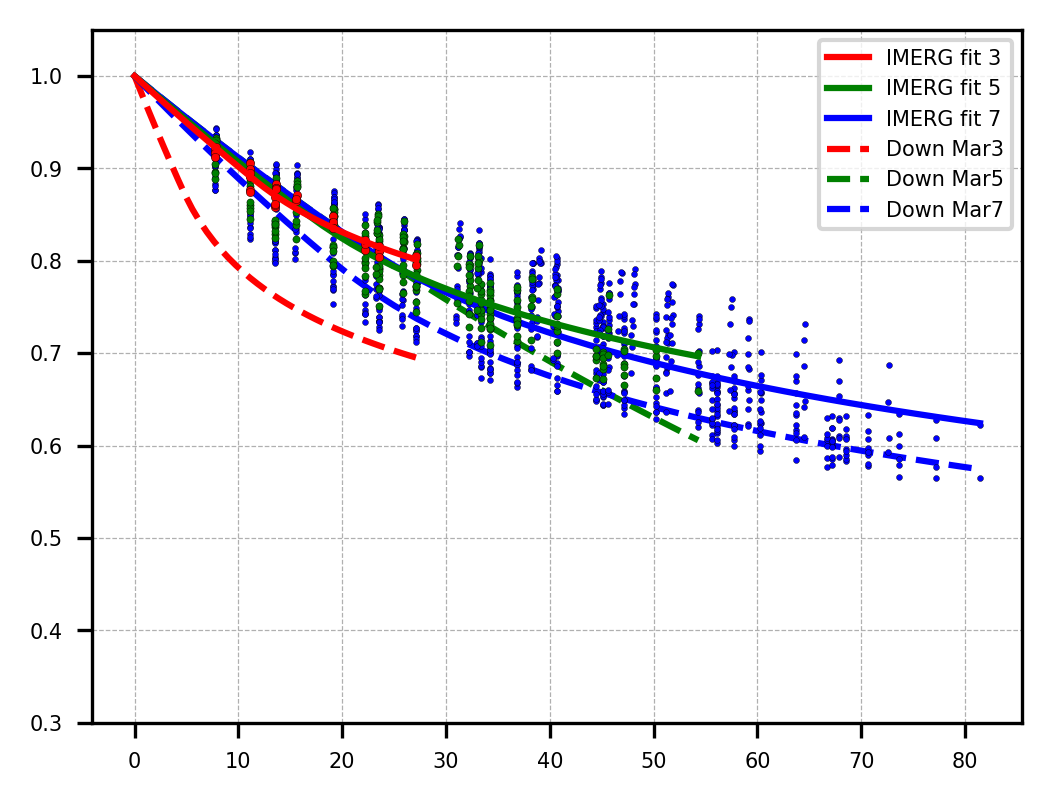

In [23]:
fig = plt.figure(figsize=(4,3),dpi=300)
gs = gridspec.GridSpec(1,1)

ax1 = plt.subplot(gs[0, 0])
ax1.scatter(box3_vdist,box3_vcorr,s=4,c='r',edgecolors='k',linewidths=0.1,zorder=10)
ax1.scatter(box5_vdist,box5_vcorr,s=3,c='g',edgecolors='k',linewidths=0.1,zorder=8)
ax1.scatter(box7_vdist,box7_vcorr,s=2,c='b',edgecolors='k',linewidths=0.1,zorder=6)

ax1 = plt.subplot(gs[0, 0])
ax1.plot(xx3, DOWN_raw.epl_fun(xx3, box3_mar[0], box3_mar[1]), '-r',zorder=10, label='IMERG fit 3')
ax1.plot(xx5, DOWN_raw.epl_fun(xx5, box5_mar[0], box5_mar[1]), '-g',zorder=8, label='IMERG fit 5')
ax1.plot(xx7, DOWN_raw.epl_fun(xx7, box7_mar[0], box7_mar[1]), '-b',zorder=6, label='IMERG fit 7')

ax1.plot(xx3, DOWN_raw.epl_fun(xx3, box3_gen_mar['eps_d'], box3_gen_mar['alp_d']), '--r', label='Down Mar3')
ax1.plot(xx5, DOWN_raw.epl_fun(xx5, box5_gen_mar['eps_d'], box5_gen_mar['alp_d']), '--g', label='Down Mar5')
ax1.plot(xx7, DOWN_raw.epl_fun(xx7, box7_gen_mar['eps_d'], box7_gen_mar['alp_d']), '--b', label='Down Mar7')

ax1.set_ylim(0.3, 1.05)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
plt.legend(fontsize=5)

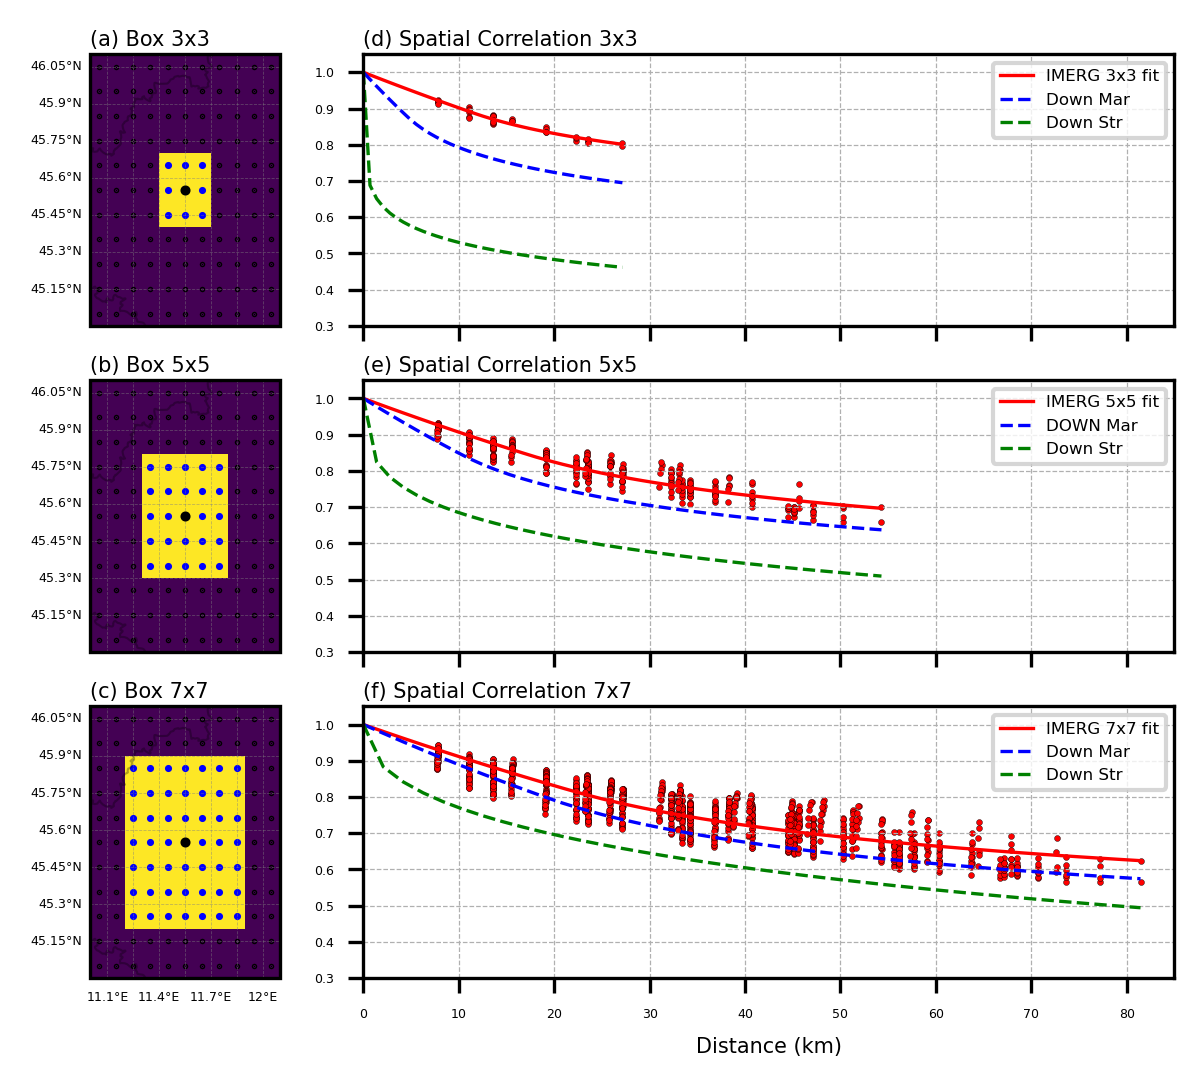

In [118]:
cmap_bin = plt.get_cmap('viridis', 3)  # Use any colormap you like with 2 discrete levels
norm = mcolors.BoundaryNorm([0, 0.5, 1], cmap_bin.N)  

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,4),dpi=300)
gs = gridspec.GridSpec(3,2)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([11, 12.1, 45, 46.1],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, alpha=0.3, zorder=10)

a1 = ax1.pcolormesh(lon2d, lat2d, box3_mask, cmap=cmap_bin, norm=norm)
box_patch = mpatches.Patch(color='yellow', label='Box Area')

scatter1 = ax1.scatter(lon2d, lat2d, s=0.1, c='k', marker='o', label='IMERG grid points')
scatter2 = ax1.scatter(box3_lon2d, box_3_lat2d, s=0.5, c='b', label='Boxgrid points')
scatter3 = ax1.scatter(lon_c, lat_c, s=2, c='k', zorder=9, label='Center point')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}
gl.xpadding = 3
gl.ypadding = 2

ax1.set_title('(a) Box 3x3', fontsize=5, loc='left', pad=2)

# ============================================================================================================================
ax2 = plt.subplot(gs[1, 0], projection = proj)
ax2.set_extent([11, 12.1, 45, 46.1],crs=proj)
VENETO.plot(facecolor='None', ax=ax2, linewidth=0.5, alpha=0.3, zorder=10)

a2 = ax2.pcolormesh(lon2d, lat2d, box5_mask, cmap=cmap_bin, norm=norm)
box_patch = mpatches.Patch(color='yellow', label='Box Area')

scatter1 = ax2.scatter(lon2d, lat2d, s=0.1, c='k', marker='o', label='IMERG grid points')
scatter2 = ax2.scatter(box5_lon2d, box5_lat2d, s=0.5, c='b', label='Boxgrid points')
scatter3 = ax2.scatter(lon_c, lat_c, s=2, c='k', zorder=9, label='Center point')

gl = ax2.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}
gl.xpadding = 3
gl.ypadding = 2

ax2.set_title('(b) Box 5x5', fontsize=5, loc='left', pad=2)

# ============================================================================================================================
ax3 = plt.subplot(gs[2, 0], projection = proj)
ax3.set_extent([11, 12.1, 45, 46.1],crs=proj)
VENETO.plot(facecolor='None', ax=ax3, linewidth=0.5, alpha=0.3, zorder=10)

a3 = ax3.pcolormesh(lon2d, lat2d, box7_mask, cmap=cmap_bin, norm=norm)
box_patch = mpatches.Patch(color='yellow', label='Box Area')

scatter1 = ax3.scatter(lon2d, lat2d, s=0.1, c='k', marker='o', label='IMERG grid points')
scatter2 = ax3.scatter(box7_lon2d, box7_lat2d, s=0.5, c='b', label='Boxgrid points')
scatter3 = ax3.scatter(lon_c, lat_c, s=2, c='k', zorder=9, label='Center point')

gl = ax3.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}
gl.xpadding = 3
gl.ypadding = 2

ax3.set_title('(c) Box 7x7', fontsize=5, loc='left', pad=2)

# ============================================================================================================================
ax4 = plt.subplot(gs[0, 1])
ax4.scatter(box3_vdist,box3_vcorr,s=2,c='r',edgecolors='k',linewidths=0.1)
ax4.plot(xx3, DOWN_raw.epl_fun(xx3, box3_mar[0], box3_mar[1]), '-r', linewidth=0.8, label='IMERG 3x3 fit')
ax4.plot(xx3, DOWN_raw.epl_fun(xx3, box3_gen_mar['eps_d'], box3_gen_mar['alp_d']), '--b', linewidth=0.8, label='Down Mar')
ax4.plot(xx3, DOWN_raw.str_exp_fun(xx3, box3_gen_str['d0_d'], box3_gen_str['mu0_d']), '--g', linewidth=0.8, label='Down Str')

ax4.set_ylim(0.3, 1.05)
ax4.tick_params(axis='both', which='major', labelsize=3)
ax4.set_xticklabels([])
ax4.set_xlim(0,85)
ax4.grid(linewidth=0.3, linestyle='--')
plt.legend(fontsize=4)

ax4.set_title('(d) Spatial Correlation 3x3', fontsize=5, loc='left', pad=2)

# ============================================================================================================================
ax5 = plt.subplot(gs[1, 1])
ax5.scatter(box5_vdist,box5_vcorr,s=2,c='r',edgecolors='k',linewidths=0.1)
ax5.plot(xx5, DOWN_raw.epl_fun(xx5, box5_mar[0], box5_mar[1]), '-r', linewidth=0.8, label='IMERG 5x5 fit')
# ax5.plot(xx5, DOWN_raw.epl_fun(xx5, box5_gen_mar['eps_d'], box5_gen_mar['alp_d']), '--b', linewidth=0.8, label='Down Mar')
ax5.plot(xx5, DOWN_raw.epl_fun(xx5, box5_lbf_mar['eps_d'], box5_lbf_mar['alp_d']), '--b', linewidth=0.8, label='DOWN Mar')
ax5.plot(xx5, DOWN_raw.str_exp_fun(xx5, box5_gen_str['d0_d'], box5_gen_str['mu0_d']), '--g', linewidth=0.8, label='Down Str')

ax5.set_ylim(0.3, 1.05)
ax5.tick_params(axis='both', which='major', labelsize=3)
ax5.set_xticklabels([])
ax5.set_xlim(0,85)
ax5.grid(linewidth=0.3, linestyle='--')
plt.legend(fontsize=4)

ax5.set_title('(e) Spatial Correlation 5x5', fontsize=5, loc='left', pad=2)

# ============================================================================================================================
ax6 = plt.subplot(gs[2, 1])
ax6.scatter(box7_vdist,box7_vcorr,s=2,c='r',edgecolors='k',linewidths=0.1)
ax6.plot(xx7, DOWN_raw.epl_fun(xx7, box7_mar[0], box7_mar[1]), '-r', linewidth=0.8, label='IMERG 7x7 fit')
ax6.plot(xx7, DOWN_raw.epl_fun(xx7, box7_gen_mar['eps_d'], box7_gen_mar['alp_d']), '--b', linewidth=0.8, label='Down Mar')
ax6.plot(xx7, DOWN_raw.str_exp_fun(xx7, box7_gen_str['d0_d'], box7_gen_str['mu0_d']), '--g', linewidth=0.8, label='Down Str')

ax6.set_ylim(0.3, 1.05)
ax6.tick_params(axis='both', which='major', labelsize=3)
ax6.grid(linewidth=0.3, linestyle='--')
ax6.set_xlim(0,85)
plt.legend(fontsize=4)

ax6.set_title('(f) Spatial Correlation 7x7', fontsize=5, loc='left', pad=2)
ax6.set_xlabel('Distance (km)', fontsize=5)

# # ============================================================================================================================
# cax = fig.add_axes([0.91, 0.196, 0.024, 0.598]) 
# cbar = plt.colorbar(a2, pad=0.04, cax=cax, ticks=[0, 1])
# cbar.set_ticks([0.25, 0.75])  
# cbar.set_ticklabels(['Not \n Covered', 'Covered'])
# cbar.ax.tick_params(labelsize=4)
# for label in cbar.ax.get_yticklabels():
#     label.set_horizontalalignment('center')
#     label.set_verticalalignment('center')
# cbar.ax.yaxis.set_tick_params(pad=10) 

# ============================================================================================================================
# ax1.legend(handles=[scatter1, scatter2, scatter3, box_patch], fontsize=4, loc=2)

# ============================================================================================================================
plt.subplots_adjust(wspace=-0.28, hspace=0.2)


In [111]:
import numpy as np
from scipy.optimize import differential_evolution

def objective_function(params, dd, cc, L1, acf='mar'):
    return DOWN_raw.myfun_sse(dd, cc, params, L1, acf=acf)

# Definir los límites de los parámetros (por ejemplo, para eps_d y alp_d)
bounds = [(0, 2000), (0, 10)]  # Límite para eps_d y alp_d, ajusta según lo que necesites

# Aplicar el algoritmo de Differential Evolution
result = differential_evolution(objective_function, bounds, args=(box3_vdist, box3_vcorr, param['L1'], 'mar'), disp=True)

# Mostrar los resultados
print(f"Mejor solución: {result.x}")
print(f"Valor de la función objetivo: {result.fun}")

differential_evolution step 1: f(x)= 0.02712874997718388
differential_evolution step 2: f(x)= 0.025423543387940357
differential_evolution step 3: f(x)= 0.025316067804977353
differential_evolution step 4: f(x)= 0.025316067804977353
differential_evolution step 5: f(x)= 0.025316067804977353
differential_evolution step 6: f(x)= 0.025248438286214585
differential_evolution step 7: f(x)= 0.025248438286214585
differential_evolution step 8: f(x)= 0.025248415886527587
differential_evolution step 9: f(x)= 0.025248415886527587
differential_evolution step 10: f(x)= 0.025248415886527587
differential_evolution step 11: f(x)= 0.025248415886527587
differential_evolution step 12: f(x)= 0.025248415886527587
differential_evolution step 13: f(x)= 0.025248415886527587
differential_evolution step 14: f(x)= 0.025248415886527587
Polishing solution with 'L-BFGS-B'
Mejor solución: [459.14496774   5.77777814]
Valor de la función objetivo: 0.02524836585710679


array([459.14496774,   5.77777814])

In [ ]:

# # ============================================================================================================================
# ax1 = plt.subplot(gs[0, 1], projection = proj)
# ax1.set_extent([10.5, 13.2, 44.7, 46.8], crs=proj)
# ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')

# ax1.scatter(lon2d, lat2d, s=0.1, c='k', marker='o')


# gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
# gl.top_labels = False
# gl.bottom_labels = True
# gl.right_labels = False
# gl.left_labels = False
# gl.xlabel_style = {'size': 3, 'color': 'k'}
# gl.ylabel_style = {'size': 3, 'color': 'k'}

# # ============================================================================================================================
# ax1 = plt.subplot(gs[0, 2], projection = proj)
# ax1.set_extent([10.5, 13.2, 44.7, 46.8], crs=proj)
# ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')

# ax1.scatter(lon2d, lat2d, s=0.1, c='k', marker='o')


# gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
# gl.top_labels = False
# gl.bottom_labels = True
# gl.right_labels = False
# gl.left_labels = False
# gl.xlabel_style = {'size': 3, 'color': 'k'}
# gl.ylabel_style = {'size': 3, 'color': 'k'}

# # ============================================================================================================================
# plt.subplots_adjust(wspace=0.05, hspace=0.05)